Import Data

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_stata("callreports_final.dta", chunksize=100000, preserve_dtypes=True)

df_raw = pd.DataFrame()

for chunk in data:
    df_raw=df_raw.append(chunk)

Additional Settings

In [33]:
%matplotlib inline
import numpy as np
import seaborn as sns
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [34]:
df_raw.equity.describe()

count    1.609478e+06
mean     4.750746e+04
std      1.277452e+06
min     -9.397490e+05
25%      1.928000e+03
50%      4.396000e+03
75%      1.074400e+04
max      1.804700e+08
Name: equity, dtype: float64

Leverage Ratio: L = Assets/Equity (Commercial banks aggregated by bhc)

In [61]:
df = df_raw[["name", "bhcid", "rssdid","assets",'year', "quarter", "equity"]]

#get data from banks without bhc
df_indBanks = df[df.bhcid == 0]

#get data from banks with bhc
df = df[df.bhcid != 0]

#group all banks belonging to one bhc
df = df.groupby(["bhcid","year", "quarter"]).agg({"assets":"sum",
                                  "equity":"sum"})

#Calculate Leverage per bhc per quarter and then take average leverage per year
df.drop(df[df.equity<=0].index, inplace=True)
df["leverageRatio"] = df.assets/df.equity
df.index.names = ["rssdid", "year", "quarter"] #rename bhcid to rssdid
df_averageLeveragePerYear = df.groupby(["rssdid","year"]).agg({"assets":"mean",
                                  "equity":"mean",
                                  "leverageRatio": "mean"})

#Calculate Leverage for banks without bhc per quarter and then take average leverage per year
df_indBanks.drop(df_indBanks[df_indBanks.equity<=0].index, inplace=True)
df_indBanks["leverageRatio"] = df_indBanks.assets/df_indBanks.equity
df_indBanks = df_indBanks[["rssdid","bhcid", "year","quarter" ,"assets", "equity", "leverageRatio"]]
df_ind_averageLeveragePerYear = df_indBanks.groupby(["rssdid","year"]).agg({"assets":"mean",
                                  "equity":"mean",
                                  "leverageRatio": "mean"})
df_indBanks.drop(["rssdid", "bhcid", "year", "quarter"], axis=1, inplace=True) # drop columns as they are already indexes


print(df_averageLeveragePerYear)
print(df_ind_averageLeveragePerYear)

#concat banks data: bhcs and independent banks
df_all_AverageLeverage = pd.concat([df_averageLeveragePerYear, df_ind_averageLeveragePerYear])

print(df_all_AverageLeverage)

                      assets     equity  leverageRatio
rssdid    year                                        
128146.0  1976.0    11456.25    1024.00      11.197244
          1977.0    13530.75    1144.50      11.806208
          1978.0    15444.25    1266.50      12.193905
          1979.0    17009.25    1320.75      12.876560
          1980.0    18700.50    1373.25      13.623024
...                      ...        ...            ...
4534101.0 2013.0   146942.00   15857.50       9.266492
4552356.0 2013.0    89248.00   10119.00       8.819844
4553960.0 2013.0   412436.00   43104.00       9.568393
4556381.0 2013.0   123832.00   14899.00       8.311430
4558901.0 2013.0  1323371.00  121814.00      10.863866

[187067 rows x 3 columns]
                     assets     equity  leverageRatio
rssdid    year                                       
28.0      1986.0    4490.25    1973.00       2.279529
          1987.0   10055.25    1952.50       5.146408
          1988.0   17126.50    1987.50    

Clean data of inf values

In [62]:
df_all_AverageLeverage.leverageRatio.replace([np.inf, -np.inf], np.nan, inplace=True)
df_all_AverageLeverage.dropna(how="all", subset=["leverageRatio"],inplace=True)
df_all_AverageLeverage.leverageRatio.describe()   

count    343003.000000
mean         12.075759
std          37.964830
min           1.000000
25%           9.176305
50%          11.196901
75%          13.181736
max       10603.272727
Name: leverageRatio, dtype: float64

Ilustrate average of leverage per year 

                             assets    equity  leverageRatio
rssdid    year   quarter                                    
128146.0  1976.0 1.0        10986.0     956.0      11.491632
                 2.0        11870.0    1030.0      11.524272
                 3.0        11410.0    1061.0      10.754006
                 4.0        11559.0    1049.0      11.019066
          1977.0 1.0        11936.0    1068.0      11.176030
...                             ...       ...            ...
4534101.0 2013.0 4.0       145922.0   15876.0       9.191358
4552356.0 2013.0 4.0        89248.0   10119.0       8.819844
4553960.0 2013.0 4.0       412436.0   43104.0       9.568393
4556381.0 2013.0 4.0       123832.0   14899.0       8.311430
4558901.0 2013.0 4.0      1323371.0  121814.0      10.863866

[717480 rows x 3 columns]


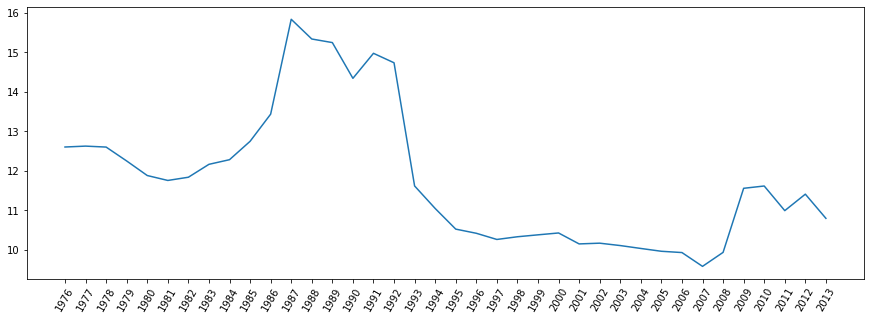

In [63]:
df_years_mean = pd.DataFrame()

df_years_mean = df_all_AverageLeverage.groupby(["year"]).agg({"leverageRatio":"mean"})
print(df)
df_years_mean.index = df_years_mean.index.astype(int)
fig, ax = plt.subplots(figsize=(15,5));
ax.set_xticks(df_years_mean.index)
ax.set_xticklabels(df_years_mean.index, rotation=60)
ax.plot(df_years_mean.leverageRatio)

Looking more detailed into assets and equity of commercial banks in 2009/2

In [64]:
df = df_raw[["name", "bhcid", "rssdid","assets",'year', "quarter", "equity"]]

df_2009_2 = df[(df.year==2009) & (df.quarter==2)]
df_2009_2["leverageRatio"] = df.assets/df.equity
df_2009_2.leverageRatio.describe()
df_2009_rssdids = df_2009_2[df_2009_2.equity<0].rssdid
#checking if banks with negative equity go bankcrupt
df[(df.rssdid.isin(df_2009_rssdids)) & (df.year==2009) & (df.quarter==4)]

,name,bhcid,rssdid,assets,year,quarter,equity


In [68]:
df[df.name.str.contains("MORGAN STANLEY")]

,name,bhcid,rssdid,assets,year,quarter,equity
1512030,MORGAN STANLEY BK NA,2162966.0,1456501.0,37638000.0,2008.0,3.0,3693000.0
1512031,MORGAN STANLEY BK NA,2162966.0,1456501.0,58054000.0,2008.0,4.0,5785000.0
1512032,MORGAN STANLEY BK NA,2162966.0,1456501.0,66238000.0,2009.0,1.0,5993000.0
1512033,MORGAN STANLEY BK NA,2162966.0,1456501.0,65328000.0,2009.0,2.0,6111000.0
1512034,MORGAN STANLEY BK NA,2162966.0,1456501.0,65487000.0,2009.0,3.0,6310000.0
1512035,MORGAN STANLEY BK NA,2162966.0,1456501.0,66159000.0,2009.0,4.0,7349000.0
1512036,MORGAN STANLEY BK NA,2162966.0,1456501.0,72292000.0,2010.0,1.0,7580000.0
1512037,MORGAN STANLEY BK NA,2162966.0,1456501.0,65746000.0,2010.0,2.0,7845000.0
1512038,MORGAN STANLEY BK NA,2162966.0,1456501.0,65518000.0,2010.0,3.0,8084000.0
1512039,MORGAN STANLEY BK NA,2162966.0,1456501.0,67534000.0,2010.0,4.0,8100000.0
